In [2]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [5]:
#dataset = pp.load_dataset("../adl-piano-midi")
dataset = pp.load_dataset("C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note = pp.dicts_from_songs(ClassicSongs)
velocity_range, time_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)

print("\nNumber of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nVelocity range      :",velocity_range[0],velocity_range[1],"\nTime range          :",time_range[0],time_range[1])

Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : C:/Users/mxrin/OneDrive/Documents/KTH_2/DD2424/Projet/DD2424-MusicGen/adl-piano-midi\adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-

In [6]:
seq_length = 30
n_batch = 200

total_samples = sum((len(song) - 1) // seq_length for song in ClassicSongs.values())

X_Channels = np.zeros((total_samples, seq_length, n_Channels))
X_Notes = np.zeros((total_samples, seq_length, n_Notes))
X_Velocities = np.zeros((total_samples, seq_length, 1))
X_Times = np.zeros((total_samples, seq_length, 1))
y_Channels = np.zeros((total_samples, seq_length, n_Channels))
y_Notes = np.zeros((total_samples, seq_length, n_Notes))
y_Velocities = np.zeros((total_samples, seq_length, 1))
y_Times = np.zeros((total_samples, seq_length, 1))

current_index = 0
for song in ClassicSongs.values():
    song_x_channels, song_y_channels = pp.label_sequences(pp.one_hot_encode(channel_to_ind, song[:, 0]), seq_length)
    song_x_notes, song_y_notes = pp.label_sequences(pp.one_hot_encode(note_to_ind, song[:, 1]), seq_length)
    song_x_velocities, song_y_velocities = pp.label_sequences(song[:, 2:3], seq_length)
    song_x_ticks, song_y_ticks = pp.label_sequences(song[:, 3:], seq_length)
    
    n_samples = song_x_channels.shape[0]
    next_index = current_index + n_samples
    
    X_Channels[current_index:next_index] = song_x_channels
    X_Notes[current_index:next_index] = song_x_notes
    X_Velocities[current_index:next_index] = song_x_velocities
    X_Times[current_index:next_index] = song_x_ticks
    y_Channels[current_index:next_index] = song_y_channels
    y_Notes[current_index:next_index] = song_y_notes
    y_Velocities[current_index:next_index] = song_y_velocities
    y_Times[current_index:next_index] = song_y_ticks
    
    current_index = next_index

In [7]:
val_split = 0.1
test_split = 0.1
train_split = 1 - val_split - test_split

n_val = int(total_samples*val_split)
n_test = int(total_samples*test_split)
indices = np.random.permutation(total_samples)
val_indices = indices[:n_val]
test_indices = indices[-n_test:]
train_indices = indices[n_val:-n_test]

Test_X_Channels = X_Channels[test_indices,:,:]
Test_X_Notes = X_Notes[test_indices,:,:]
Test_X_Velocities = X_Velocities[test_indices,:,:]
Test_X_Times = X_Times[test_indices,:,:]
Test_y_Channels = y_Channels[test_indices,:,:]
Test_y_Notes = y_Notes[test_indices,:,:]
Test_y_Velocities = y_Velocities[test_indices,:,:]
Test_y_Times = y_Times[test_indices,:,:]

Val_X_Channels = X_Channels[val_indices,:,:]
Val_X_Notes = X_Notes[val_indices,:,:]
Val_X_Velocities = X_Velocities[val_indices,:,:]
Val_X_Times = X_Times[val_indices,:,:]
Val_y_Channels = y_Channels[val_indices,:,:]
Val_y_Notes = y_Notes[val_indices,:,:]
Val_y_Velocities = y_Velocities[val_indices,:,:]
Val_y_Times = y_Times[val_indices,:,:]


X_Channels = X_Channels[train_indices,:,:]
X_Notes = X_Notes[train_indices,:,:]
X_Velocities = X_Velocities[train_indices,:,:]
X_Times = X_Times[train_indices,:,:]
y_Channels = y_Channels[train_indices,:,:]
y_Notes = y_Notes[train_indices,:,:]
y_Velocities = y_Velocities[train_indices,:,:]
y_Times = y_Times[train_indices,:,:]

print(X_Channels.shape)
print(X_Notes.shape)
print(X_Velocities.shape)
print(X_Times.shape)
print(Val_X_Times.shape)
print(Test_X_Times.shape)

(56724, 30, 12)
(56724, 30, 105)
(56724, 30, 1)
(56724, 30, 1)
(7090, 30, 1)
(7090, 30, 1)


In [8]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [9]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

def tol_accuracy(y_true, y_pred):
    threshold = 0.1
    difference = tf.abs(tf.subtract(y_true, y_pred)) - threshold
    correct_predictions = tf.where(difference <= 0, True, False)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

def plot_training_results(title,loss,channels_accuracy,notes_accuracy,velocities_accuracy,times_accuracy,val_loss,val_channels_accuracy,val_notes_accuracy,val_velocities_accuracy,val_times_accuracy):
    n = len(loss)+1
    x = range(1,n)
    x_ticks = range(1,n,max(1,n//10))

    plt.figure()
    plt.plot(x, loss, label="Training loss")
    plt.plot(x, val_loss, label="Validation loss")
    plt.title(title)
    plt.legend()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.xticks(x_ticks)
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(9, 8))

    axs[0,0].plot(x, channels_accuracy, label="Training set")
    axs[0,0].plot(x, val_channels_accuracy, label="Validation set")
    axs[0,0].legend()
    axs[0,0].set_ylim([0,1])
    axs[0,0].set_title("Channels")
    axs[0,0].set_xlabel("Number of epochs")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,0].set_xticks(x_ticks)

    axs[0,1].plot(x, notes_accuracy, label="Training set")
    axs[0,1].plot(x, val_notes_accuracy, label="Validation set")
    axs[0,1].legend()
    axs[0,1].set_ylim([0,1])
    axs[0,1].set_title("Notes")
    axs[0,1].set_xlabel("Number of epochs")
    axs[0,1].set_ylabel("Accuracy")
    axs[0,1].set_xticks(x_ticks)

    axs[1,0].plot(x, velocities_accuracy, label="Training set")
    axs[1,0].plot(x, val_velocities_accuracy, label="Validation set")
    axs[1,0].legend()
    axs[1,0].set_ylim([0,1])
    axs[1,0].set_title("Velocity")
    axs[1,0].set_xlabel("Number of epochs")
    axs[1,0].set_ylabel("Accuracy")
    axs[1,0].set_xticks(x_ticks)

    axs[1,1].plot(x, times_accuracy, label="Training set")
    axs[1,1].plot(x, val_times_accuracy, label="Validation set")
    axs[1,1].legend()
    axs[1,1].set_ylim([0,1])
    axs[1,1].set_title("Time")
    axs[1,1].set_xlabel("Number of epochs")
    axs[1,1].set_ylabel("Accuracy")
    axs[1,1].set_xticks(x_ticks)

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 1, 1])

In [59]:
dim = 300

lossRNN = []
channels_accuracyRNN = []
notes_accuracyRNN = []
velocities_accuracyRNN = []
times_accuracyRNN = []

val_lossRNN = []
val_channels_accuracyRNN = []
val_notes_accuracyRNN = []
val_velocities_accuracyRNN = []
val_times_accuracyRNN = []

# Define input layer
input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_times = Input(shape=(None, 1))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_times]))

# Define Dense layer for each branch
channels_output = Dense(units=n_Channels)(rnn_output)
notes_output = Dense(units=n_Notes)(rnn_output)
velocities_output = Dense(units=1)(rnn_output)
times_output = Dense(units=1)(rnn_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
final_channels = Softmax(name="Channels")(channels_output)
final_notes = Softmax(name="Notes")(notes_output)
final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output)
final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output)

# Define the model with inputs and outputs
RNN_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[final_channels, final_notes, final_velocities, final_times], name="RNN_model")

RNN_model.summary()

Model: "RNN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                          

In [61]:
n_epochs = 10

lossesRNN = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}


loss_weightsRNN = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsRNN = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

RNN_model.compile(optimizer='adam', loss=lossesRNN, loss_weights=loss_weightsRNN, metrics=metricsRNN)
history = RNN_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))

lossRNN += history.history['loss']
channels_accuracyRNN += history.history['Channels_accuracy']
notes_accuracyRNN += history.history['Notes_accuracy']
velocities_accuracyRNN += history.history['Velocities_rounded_accuracy']
times_accuracyRNN += history.history['Times_tol_accuracy']

val_lossRNN += history.history['val_loss']
val_channels_accuracyRNN += history.history['val_Channels_accuracy']
val_notes_accuracyRNN += history.history['val_Notes_accuracy']
val_velocities_accuracyRNN += history.history['val_Velocities_rounded_accuracy']
val_times_accuracyRNN += history.history['val_Times_tol_accuracy']

Epoch 1/10
281/281 [==============================] - 58s 176ms/step - loss: 38.2766 - Channels_loss: 0.8541 - Notes_loss: 3.9578 - Velocities_loss: 903.0278 - Times_loss: 722.2706 - Channels_accuracy: 0.6737 - Notes_accuracy: 0.0398 - Velocities_rounded_accuracy: 0.0111 - Times_tol_accuracy: 0.0015 - val_loss: 35.7303 - val_Channels_loss: 0.7471 - val_Notes_loss: 3.9024 - val_Velocities_loss: 792.2257 - val_Times_loss: 101.6665 - val_Channels_accuracy: 0.6972 - val_Notes_accuracy: 0.0447 - val_Velocities_rounded_accuracy: 0.0045 - val_Times_tol_accuracy: 0.0046
Epoch 2/10
281/281 [==============================] - 43s 154ms/step - loss: 34.6433 - Channels_loss: 0.7037 - Notes_loss: 3.8703 - Velocities_loss: 747.0045 - Times_loss: 68.7450 - Channels_accuracy: 0.7010 - Notes_accuracy: 0.0540 - Velocities_rounded_accuracy: 0.0095 - Times_tol_accuracy: 0.0088 - val_loss: 34.2623 - val_Channels_loss: 0.6676 - val_Notes_loss: 3.8139 - val_Velocities_loss: 742.9378 - val_Times_loss: 51.9064 

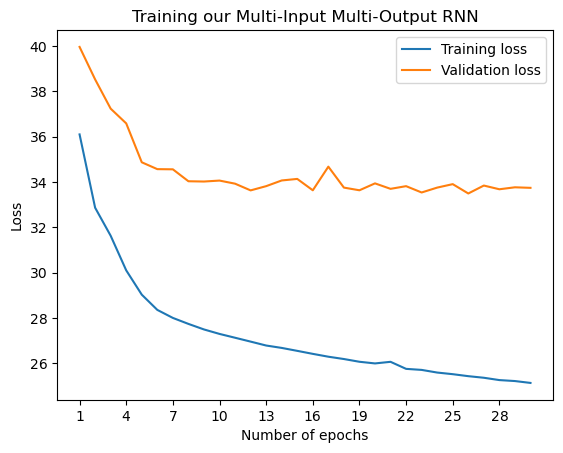

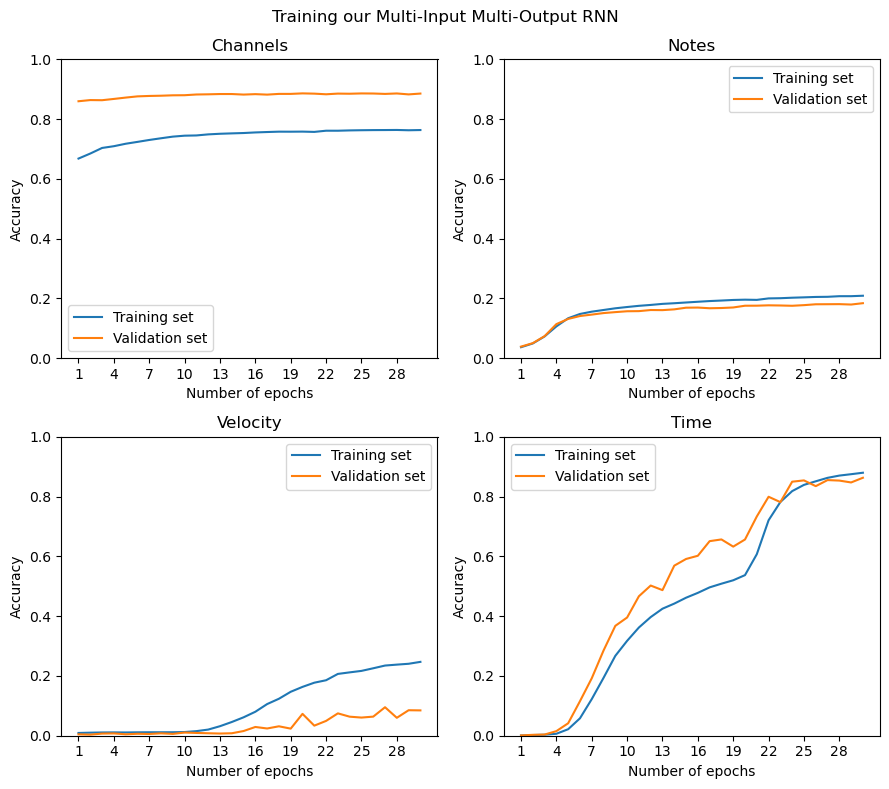

In [49]:
plot_training_results("Training our Multi-Input Multi-Output RNN",lossRNN,channels_accuracyRNN,notes_accuracyRNN,velocities_accuracyRNN,times_accuracyRNN,val_lossRNN,val_channels_accuracyRNN,val_notes_accuracyRNN,val_velocities_accuracyRNN,val_times_accuracyRNN)

In [33]:
dim = 140

lossLSTM = []
channels_accuracyLSTM = []
notes_accuracyLSTM = []
velocities_accuracyLSTM = []
times_accuracyLSTM = []

val_lossLSTM = []
val_channels_accuracyLSTM = []
val_notes_accuracyLSTM = []
val_velocities_accuracyLSTM = []
val_times_accuracyLSTM = []

# Define input layers for notes and velocities
#input_channels = Input(shape=(None, n_Channels))
#input_notes = Input(shape=(None, n_Notes))
#input_velocities = Input(shape=(None, 1))
#input_times = Input(shape=(None, 1))

# Define LSTM layer
lstm_output = LSTM(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_times]))

# Define Dense layer for each branch
channels_output_lstm = Dense(units=n_Channels)(lstm_output)
notes_output_lstm = Dense(units=n_Notes)(lstm_output)
velocities_output_lstm = Dense(units=1)(lstm_output)
times_output_lstm = Dense(units=1)(lstm_output)

# Use Lambda layer to split the output of SimpleLSTM into two branches
lstm_final_channels = Softmax(name="Channels")(channels_output_lstm)
lstm_final_notes = Softmax(name="Notes")(notes_output_lstm)
lstm_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_lstm)
lstm_final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output_lstm)

# Define the model with inputs and outputs
LSTM_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[lstm_final_channels, lstm_final_notes, lstm_final_velocities, lstm_final_times], name="LSTM_model")

LSTM_model.summary()

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                         

In [45]:
n_epochs = 10

lossesLSTM = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}


loss_weightsLSTM = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsLSTM = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

LSTM_model.compile(optimizer='adam', loss=lossesLSTM, loss_weights=loss_weightsLSTM, metrics=metricsLSTM)
history = LSTM_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))

lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']
velocities_accuracyLSTM += history.history['Velocities_rounded_accuracy']
times_accuracyLSTM += history.history['Times_tol_accuracy']

val_lossLSTM += history.history['val_loss']
val_channels_accuracyLSTM += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM += history.history['val_Velocities_rounded_accuracy']
val_times_accuracyLSTM += history.history['val_Times_tol_accuracy']

Epoch 1/10
280/280 [==============================] - 39s 126ms/step - loss: 24.9110 - Channels_loss: 0.4771 - Notes_loss: 2.8735 - Velocities_loss: 515.2563 - Times_loss: 0.7881 - Channels_accuracy: 0.7594 - Notes_accuracy: 0.2279 - Velocities_rounded_accuracy: 0.2481 - Times_tol_accuracy: 0.4243 - val_loss: 32.0184 - val_Channels_loss: 0.2776 - val_Notes_loss: 2.9614 - val_Velocities_loss: 853.6221 - val_Times_loss: 0.3579 - val_Channels_accuracy: 0.8868 - val_Notes_accuracy: 0.2178 - val_Velocities_rounded_accuracy: 0.0688 - val_Times_tol_accuracy: 0.5654
Epoch 2/10
280/280 [==============================] - 31s 111ms/step - loss: 24.8012 - Channels_loss: 0.4756 - Notes_loss: 2.8646 - Velocities_loss: 512.0165 - Times_loss: 0.3498 - Channels_accuracy: 0.7603 - Notes_accuracy: 0.2302 - Velocities_rounded_accuracy: 0.2434 - Times_tol_accuracy: 0.6284 - val_loss: 32.0431 - val_Channels_loss: 0.2771 - val_Notes_loss: 2.9567 - val_Velocities_loss: 856.0514 - val_Times_loss: 0.1957 - val_

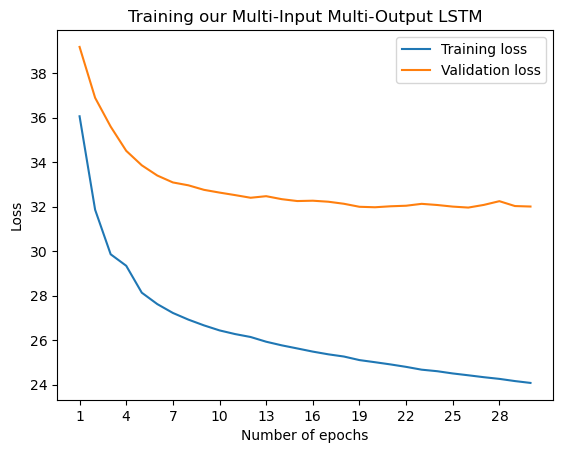

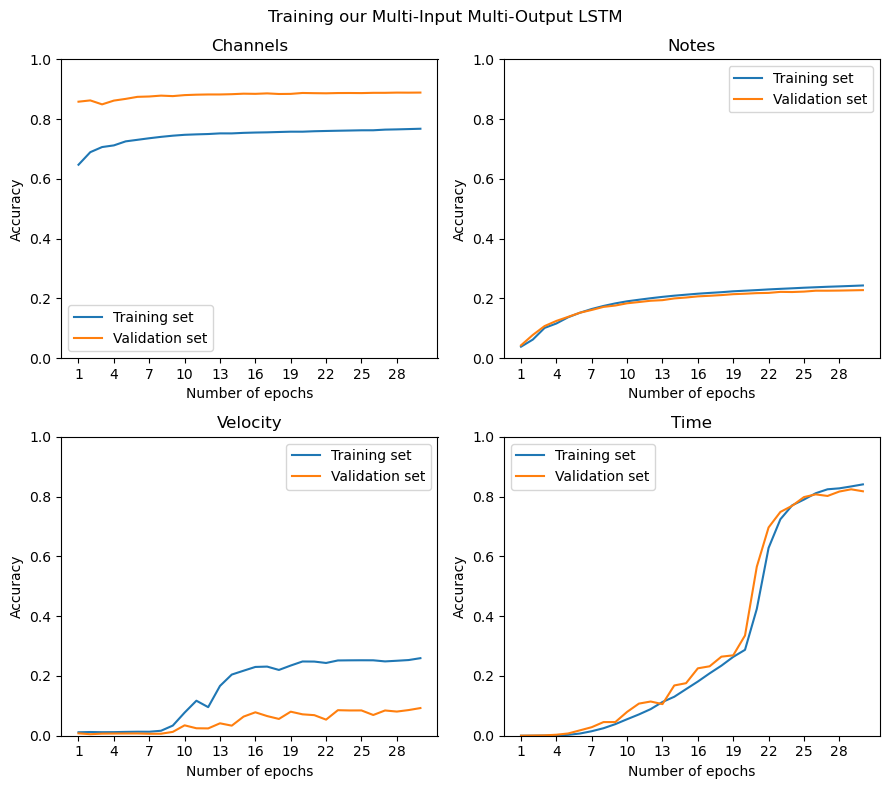

In [50]:
plot_training_results("Training our Multi-Input Multi-Output LSTM",lossLSTM,channels_accuracyLSTM,notes_accuracyLSTM,velocities_accuracyLSTM,times_accuracyLSTM,val_lossLSTM,val_channels_accuracyLSTM,val_notes_accuracyLSTM,val_velocities_accuracyLSTM,val_times_accuracyLSTM)

In [51]:
dim_l1 = 140
dim_l2 = 100

lossLSTM2 = []
channels_accuracyLSTM2 = []
notes_accuracyLSTM2 = []
velocities_accuracyLSTM2 = []
times_accuracyLSTM2 = []

val_lossLSTM2 = []
val_channels_accuracyLSTM2 = []
val_notes_accuracyLSTM2 = []
val_velocities_accuracyLSTM2 = []
val_times_accuracyLSTM2 = []

# Define input layers for notes and velocities
#input_channels = Input(shape=(None, n_Channels))
#input_notes = Input(shape=(None, n_Notes))
#input_velocities = Input(shape=(None, 1))
#input_times = Input(shape=(None, 1))

# Define LSTM2 layer
lstm2_fl = LSTM(units=dim_l1, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_times]))
lstm2_output = LSTM(units=dim_l2, return_sequences=True)(lstm2_fl)

# Define Dense layer for each branch
channels_output_lstm2 = Dense(units=n_Channels)(lstm2_output)
notes_output_lstm2 = Dense(units=n_Notes)(lstm2_output)
velocities_output_lstm2 = Dense(units=1)(lstm2_output)
times_output_lstm2 = Dense(units=1)(lstm2_output)

# Use Lambda layer to split the output of SimpleLSTM2 into two branches
lstm2_final_channels = Softmax(name="Channels")(channels_output_lstm2)
lstm2_final_notes = Softmax(name="Notes")(notes_output_lstm2)
lstm2_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_lstm2)
lstm2_final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output_lstm2)

# Define the model with inputs and outputs
LSTM2_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[lstm2_final_channels, lstm2_final_notes, lstm2_final_velocities, lstm2_final_times], name="LSTM2_model")

LSTM2_model.summary()

Model: "LSTM2_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 105)]  0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                        

In [52]:
n_epochs = 30

lossesLSTM2 = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}


loss_weightsLSTM2 = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsLSTM2 = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

LSTM2_model.compile(optimizer='adam', loss=lossesLSTM2, loss_weights=loss_weightsLSTM2, metrics=metricsLSTM2)
history = LSTM2_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))

lossLSTM2 += history.history['loss']
channels_accuracyLSTM2 += history.history['Channels_accuracy']
notes_accuracyLSTM2 += history.history['Notes_accuracy']
velocities_accuracyLSTM2 += history.history['Velocities_rounded_accuracy']
times_accuracyLSTM2 += history.history['Times_tol_accuracy']

val_lossLSTM2 += history.history['val_loss']
val_channels_accuracyLSTM2 += history.history['val_Channels_accuracy']
val_notes_accuracyLSTM2 += history.history['val_Notes_accuracy']
val_velocities_accuracyLSTM2 += history.history['val_Velocities_rounded_accuracy']
val_times_accuracyLSTM2 += history.history['val_Times_tol_accuracy']

Epoch 1/30
280/280 [==============================] - 90s 286ms/step - loss: 35.5357 - Channels_loss: 0.9312 - Notes_loss: 4.0021 - Velocities_loss: 752.9749 - Times_loss: 1304.9658 - Channels_accuracy: 0.6639 - Notes_accuracy: 0.0349 - Velocities_rounded_accuracy: 0.0846 - Times_tol_accuracy: 6.5476e-06 - val_loss: 39.2953 - val_Channels_loss: 0.5588 - val_Notes_loss: 4.0259 - val_Velocities_loss: 944.3103 - val_Times_loss: 203.1506 - val_Channels_accuracy: 0.8595 - val_Notes_accuracy: 0.0339 - val_Velocities_rounded_accuracy: 0.0838 - val_Times_tol_accuracy: 2.0833e-05
Epoch 2/30
280/280 [==============================] - 80s 284ms/step - loss: 32.3144 - Channels_loss: 0.7150 - Notes_loss: 3.8940 - Velocities_loss: 624.3456 - Times_loss: 99.4759 - Channels_accuracy: 0.6832 - Notes_accuracy: 0.0413 - Velocities_rounded_accuracy: 0.2143 - Times_tol_accuracy: 1.0893e-04 - val_loss: 37.8894 - val_Channels_loss: 0.4665 - val_Notes_loss: 3.9485 - val_Velocities_loss: 895.6927 - val_Times_l

280/280 [==============================] - 50s 179ms/step - loss: 23.2888 - Channels_loss: 0.4610 - Notes_loss: 2.7942 - Velocities_loss: 454.3684 - Times_loss: 0.4823 - Channels_accuracy: 0.7820 - Notes_accuracy: 0.2361 - Velocities_rounded_accuracy: 0.2660 - Times_tol_accuracy: 0.4195 - val_loss: 31.8129 - val_Channels_loss: 0.2738 - val_Notes_loss: 2.9266 - val_Velocities_loss: 852.1575 - val_Times_loss: 0.3054 - val_Channels_accuracy: 0.8864 - val_Notes_accuracy: 0.2175 - val_Velocities_rounded_accuracy: 0.0927 - val_Times_tol_accuracy: 0.4675
Epoch 30/30
280/280 [==============================] - 50s 178ms/step - loss: 23.1680 - Channels_loss: 0.4596 - Notes_loss: 2.7869 - Velocities_loss: 450.1863 - Times_loss: 0.4299 - Channels_accuracy: 0.7828 - Notes_accuracy: 0.2386 - Velocities_rounded_accuracy: 0.2675 - Times_tol_accuracy: 0.4497 - val_loss: 31.7385 - val_Channels_loss: 0.2734 - val_Notes_loss: 2.9142 - val_Velocities_loss: 851.5306 - val_Times_loss: 0.2862 - val_Channels_a

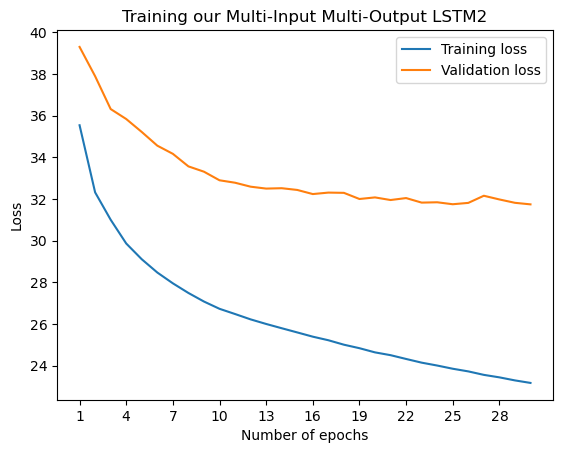

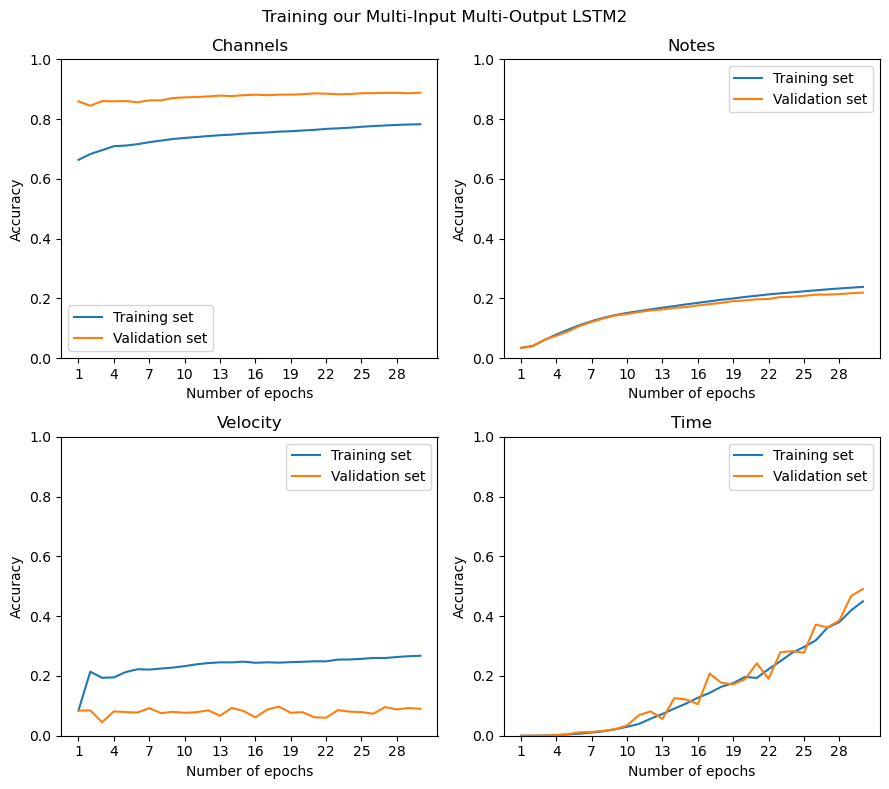

In [53]:
plot_training_results("Training our Multi-Input Multi-Output LSTM2",lossLSTM2,channels_accuracyLSTM2,notes_accuracyLSTM2,velocities_accuracyLSTM2,times_accuracyLSTM2,val_lossLSTM2,val_channels_accuracyLSTM2,val_notes_accuracyLSTM2,val_velocities_accuracyLSTM2,val_times_accuracyLSTM2)

GRU

In [11]:
##GRU
dim = 250

lossGRU = []
channels_accuracyGRU = []
notes_accuracyGRU = []
velocities_accuracyGRU = []
times_accuracyGRU = []

val_lossGRU = []
val_channels_accuracyGRU = []
val_notes_accuracyGRU = []
val_velocities_accuracyGRU = []
val_times_accuracyGRU = []

input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_times = Input(shape=(None, 1))


# Define GRU layer
gru_output = GRU(units = dim, return_sequences = True)(concatenate([input_channels, input_notes, input_velocities, input_times]))

# Define Dense layer for each branch
channels_output_gru = Dense(units=n_Channels)(gru_output)
notes_output_gru = Dense(units=n_Notes)(gru_output)
velocities_output_gru = Dense(units=1)(gru_output)
times_output_gru = Dense(units=1)(gru_output)

# Use Lambda layer to split the output of SimpleGRU into two branches
gru_final_channels = Softmax(name="Channels")(channels_output_gru)
gru_final_notes = Softmax(name="Notes")(notes_output_gru)
gru_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_gru)
gru_final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output_gru) 

GRU_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[gru_final_channels, gru_final_notes, gru_final_velocities, gru_final_times], name="GRU_model")
GRU_model.summary()

Model: "GRU_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                          

In [13]:
n_epochs = 20

lossesGRU = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}

loss_weightsGRU = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsGRU = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

GRU_model.compile(optimizer='adam', loss=lossesGRU, loss_weights=loss_weightsGRU, metrics=metricsGRU)
history = GRU_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))

lossGRU += history.history['loss']
channels_accuracyGRU += history.history['Channels_accuracy']
notes_accuracyGRU += history.history['Notes_accuracy']
velocities_accuracyGRU += history.history['Velocities_rounded_accuracy']
times_accuracyGRU += history.history['Times_tol_accuracy']

val_lossGRU += history.history['val_loss']
val_channels_accuracyGRU += history.history['val_Channels_accuracy']
val_notes_accuracyGRU += history.history['val_Notes_accuracy']
val_velocities_accuracyGRU += history.history['val_Velocities_rounded_accuracy']
val_times_accuracyGRU += history.history['val_Times_tol_accuracy']

Epoch 1/20
284/284 [==============================] - 92s 290ms/step - loss: 37.9549 - Channels_loss: 0.8010 - Notes_loss: 3.9443 - Velocities_loss: 891.6361 - Times_loss: 310.2097 - Channels_accuracy: 0.6946 - Notes_accuracy: 0.0441 - Velocities_rounded_accuracy: 0.0088 - Times_tol_accuracy: 0.0027 - val_loss: 34.8281 - val_Channels_loss: 0.6779 - val_Notes_loss: 3.8569 - val_Velocities_loss: 760.2197 - val_Times_loss: 74.8572 - val_Channels_accuracy: 0.7042 - val_Notes_accuracy: 0.0572 - val_Velocities_rounded_accuracy: 0.0129 - val_Times_tol_accuracy: 0.0086
Epoch 2/20
284/284 [==============================] - 85s 298ms/step - loss: 33.2725 - Channels_loss: 0.6171 - Notes_loss: 3.6438 - Velocities_loss: 737.2377 - Times_loss: 44.9645 - Channels_accuracy: 0.7194 - Notes_accuracy: 0.0853 - Velocities_rounded_accuracy: 0.0107 - Times_tol_accuracy: 0.0217 - val_loss: 31.8918 - val_Channels_loss: 0.5785 - val_Notes_loss: 3.4077 - val_Velocities_loss: 728.2014 - val_Times_loss: 28.1320 -

In [18]:
##save the model
GRU_model.save("GRU_model.h5")

In [19]:
##reopen the model
from keras.models import load_model
GRU_model = load_model("GRU_model.h5")
GRU_model.evaluate([Test_X_Channels, Test_X_Notes, Test_X_Velocities, Test_X_Times], [Test_y_Channels, Test_y_Notes, Test_y_Velocities, Test_y_Times])

ValueError: Unknown metric function: 'rounded_accuracy'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

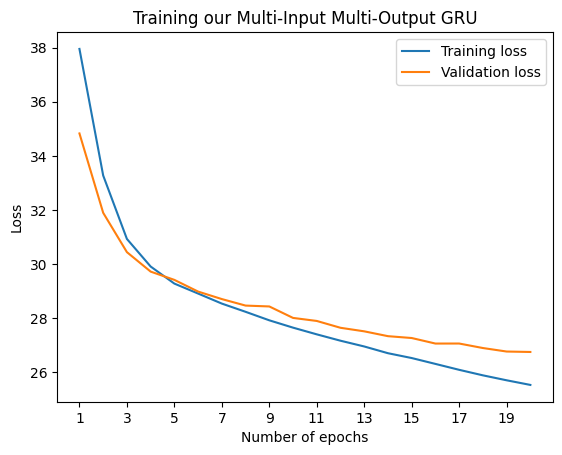

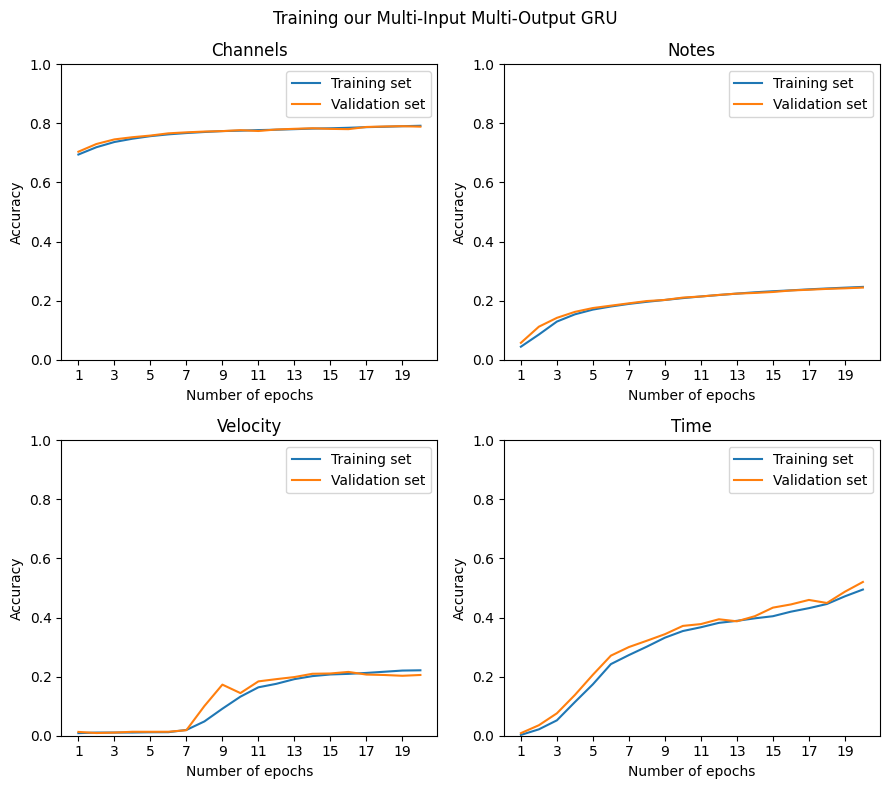

In [14]:
plot_training_results("Training our Multi-Input Multi-Output GRU",lossGRU,channels_accuracyGRU,notes_accuracyGRU,velocities_accuracyGRU,times_accuracyGRU,val_lossGRU,val_channels_accuracyGRU,val_notes_accuracyGRU,val_velocities_accuracyGRU,val_times_accuracyGRU)

3 layers GRU

In [15]:
##3 layers GRU
dim_l1 = 200
dim_l2 = 200
dim_l3 = 200

lossGRU3 = []
channels_accuracyGRU3 = []
notes_accuracyGRU3 = []
velocities_accuracyGRU3 = []
times_accuracyGRU3 = []

val_lossGRU3 = []
val_channels_accuracyGRU3 = []
val_notes_accuracyGRU3 = []
val_velocities_accuracyGRU3 = []
val_times_accuracyGRU3 = []

input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_times = Input(shape=(None, 1))

# Define GRU layer
gru3_fl = GRU(units = dim_l1, return_sequences = True)(concatenate([input_channels, input_notes, input_velocities, input_times]))
gru3_sl = GRU(units = dim_l2, return_sequences = True)(gru3_fl)
gru3_output = GRU(units = dim_l3, return_sequences = True)(gru3_sl)

# Define Dense layer for each branch
channels_output_gru3 = Dense(units=n_Channels)(gru3_output)
notes_output_gru3 = Dense(units=n_Notes)(gru3_output)
velocities_output_gru3 = Dense(units=1)(gru3_output)
times_output_gru3 = Dense(units=1)(gru3_output)

# Use Lambda layer to split the output of SimpleGRU3 into two branches
gru3_final_channels = Softmax(name="Channels")(channels_output_gru3)
gru3_final_notes = Softmax(name="Notes")(notes_output_gru3)
gru3_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_gru3)
gru3_final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output_gru3)

GRU3_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[gru3_final_channels, gru3_final_notes, gru3_final_velocities, gru3_final_times], name="GRU3_model")
GRU3_model.summary()

Model: "GRU3_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                         

In [16]:
n_epochs = 20

lossesGRU = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}

loss_weightsGRU = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsGRU = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

GRU3_model.compile(optimizer='adam', loss=lossesGRU, loss_weights=loss_weightsGRU, metrics=metricsGRU)
history = GRU3_model.fit([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times], epochs=n_epochs, batch_size=n_batch, validation_data=([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times]))
lossGRU3 += history.history['loss']
channels_accuracyGRU3 += history.history['Channels_accuracy']
notes_accuracyGRU3 += history.history['Notes_accuracy']
velocities_accuracyGRU3 += history.history['Velocities_rounded_accuracy']
times_accuracyGRU3 += history.history['Times_tol_accuracy']

val_lossGRU3 += history.history['val_loss']
val_channels_accuracyGRU3 += history.history['val_Channels_accuracy']
val_notes_accuracyGRU3 += history.history['val_Notes_accuracy']
val_velocities_accuracyGRU3 += history.history['val_Velocities_rounded_accuracy']
val_times_accuracyGRU3 += history.history['val_Times_tol_accuracy']

Epoch 1/20
284/284 [==============================] - 219s 664ms/step - loss: 37.5858 - Channels_loss: 0.8535 - Notes_loss: 3.9707 - Velocities_loss: 865.2554 - Times_loss: 947.5719 - Channels_accuracy: 0.6908 - Notes_accuracy: 0.0383 - Velocities_rounded_accuracy: 0.0113 - Times_tol_accuracy: 2.0313e-05 - val_loss: 35.0500 - val_Channels_loss: 0.7416 - val_Notes_loss: 3.9152 - val_Velocities_loss: 755.1528 - val_Times_loss: 91.9530 - val_Channels_accuracy: 0.7014 - val_Notes_accuracy: 0.0399 - val_Velocities_rounded_accuracy: 0.0171 - val_Times_tol_accuracy: 8.7963e-05
Epoch 2/20
284/284 [==============================] - 180s 632ms/step - loss: 34.2641 - Channels_loss: 0.6807 - Notes_loss: 3.8699 - Velocities_loss: 728.7080 - Times_loss: 55.1465 - Channels_accuracy: 0.7021 - Notes_accuracy: 0.0452 - Velocities_rounded_accuracy: 0.1091 - Times_tol_accuracy: 4.2375e-04 - val_loss: 33.4657 - val_Channels_loss: 0.6324 - val_Notes_loss: 3.7401 - val_Velocities_loss: 722.4380 - val_Times_l

In [22]:
##save the weights
GRU3_model.save_weights("GRU3_model.h5")
##REOPEN THE MODEL
GRU3_model.load_weights("GRU3_model.h5")
GRU3_model.evaluate([Test_X_Channels, Test_X_Notes, Test_X_Velocities, Test_X_Times], [Test_y_Channels, Test_y_Notes, Test_y_Velocities, Test_y_Times])

222/222 [==============================] - 14s 60ms/step - loss: 25.2003 - Channels_loss: 0.4320 - Notes_loss: 2.7128 - Velocities_loss: 571.0075 - Times_loss: 0.9587 - Channels_accuracy: 0.8073 - Notes_accuracy: 0.2603 - Velocities_rounded_accuracy: 0.2521 - Times_tol_accuracy: 0.4549


[25.200273513793945,
 0.4319561719894409,
 2.7128288745880127,
 571.0075073242188,
 0.9587026238441467,
 0.8072919845581055,
 0.26031970977783203,
 0.252106249332428,
 0.4549376964569092]

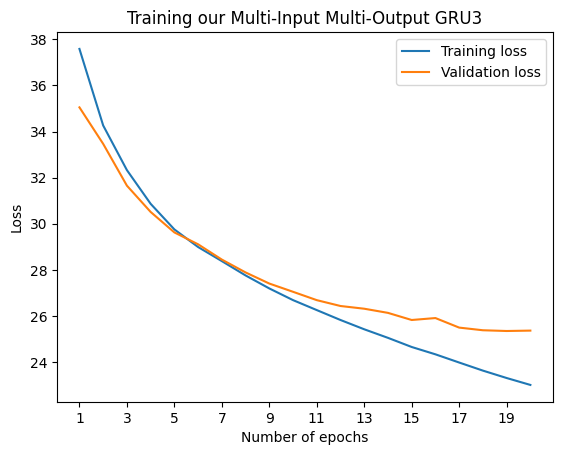

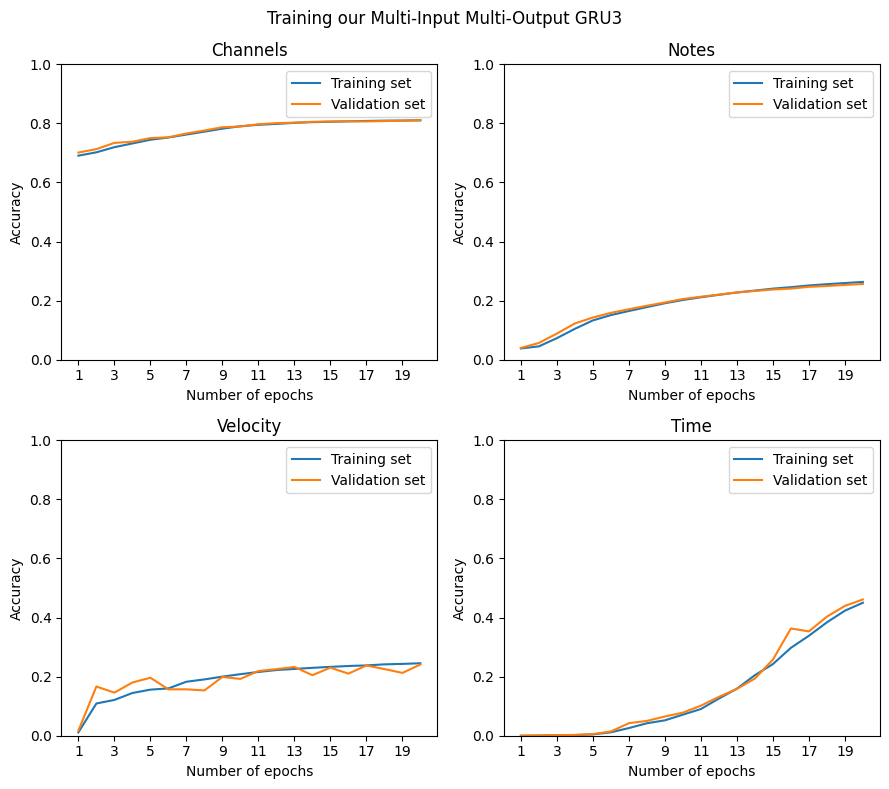

In [17]:
plot_training_results("Training our Multi-Input Multi-Output GRU3",lossGRU3,channels_accuracyGRU3,notes_accuracyGRU3,velocities_accuracyGRU3,times_accuracyGRU3,val_lossGRU3,val_channels_accuracyGRU3,val_notes_accuracyGRU3,val_velocities_accuracyGRU3,val_times_accuracyGRU3)

Generating music

In [20]:
import utils as ut
#LSTM_model.predict([X_Channels[0:1,0:1,:], X_notes[0:1,0:1,:], X_velocities[0:1,0:1,:], X_times[0:1,0:1,:]])
gen = ut.generate(RNN_model,[X_Channels[2:3,:,:], X_Notes[2:3,:,:], X_Velocities[2:3,:,:], X_Times[2:3,:,:]],30,ind_to_channel,ind_to_note,mode="SoftMax",T=0.8)
gen


NameError: name 'RNN_model' is not defined

In [76]:
channels,notes,velocities,times = ut.create_midi(gen)
print(channels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


In [77]:
print(notes)
print(velocities)
print(times)

[63, 64, 66, 57, 60, 66, 69, 83, 83, 59, 71, 55, 67, 66, 57, 71, 76, 62, 66, 77, 78, 78, 75, 51, 56, 60, 64, 67, 65, 56]
[40, 21, 16, 15, 15, 14, 15, 15, 11, 12, 15, 14, 16, 16, 16, 15, 13, 15, 16, 16, 15, 13, 12, 13, 18, 21, 16, 15, 15, 15]
[0.16556454, 0.60298634, 0.6616505, 0.94977105, 0.8230647, 0.63421273, 0.9750114, 0.93751144, 1.2692142, 1.3183489, 0.95238066, 1.1331534, 0.90501285, 0.7834816, 0.95951253, 0.8172446, 1.1269197, 1.4664081, 0.89629745, 0.97040933, 1.3752398, 1.3121512, 1.3356915, 0.9563784, 0.91089994, 1.1304889, 0.6354053, 0.69452226, 0.7820189, 0.72880524]


In [82]:
import pygame
pygame.init()
pygame.mixer.music.load("output.mid")
pygame.mixer.music.play()